In [5]:
import settings
import os
from emoji import Emoji, EmojiOutputFormat
import numpy as np
from main import batch_load, map_y
from sklearn import metrics, decomposition
import random

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

In [6]:
def grayscale_and_resize_load():
    # Read the data
    DATA_DIR = os.environ["DATA_DIR"]
    X, y = batch_load(DATA_DIR, {"Facebook": "Meta", "Microsoft": "Microsoft", "Apple": "Apple"}, output_size=(36,36), output_format=EmojiOutputFormat.grayscale)
    # Transform y
    y = map_y(y)
    
    # Preprocessing the input data
    # Normalize input vector
    X = X/ 255.0
    y = y/ 2
    return X,y

In [7]:
def RGB_and_PCA_load():
    # Read the data
    DATA_DIR = os.environ["DATA_DIR"]
    X, y = batch_load(DATA_DIR, {"Facebook": "Meta", "Microsoft": "Microsoft", "Apple": "Apple"}, output_size=(72,72), output_format=EmojiOutputFormat.RGB)
    # Transform y
    y = map_y(y)
    
    # Preprocessing the input data
    # Normalize input vector
    X = X/ 255.0
    y = y/ 2

    pca = decomposition.PCA(36*36)
    X = pca.fit_transform(X)
    return X,y

In [8]:
# Change how you want the data loo like
X,y = RGB_and_PCA_load()
# X,y = grayscale_and_resize_load()

/home/loe/.local/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# random.shuffle(iris) # This thing breaks list. I do not know why.
X_new = X.copy()
y_new = y.copy()
sequence = []
random.seed(114)
while len(sequence) != X.shape[0]:
    i = random.randint(0,X.shape[0]-1)
    if i not in sequence:
        sequence.append(i)
#print(sequence)
for i_ind, i_val in enumerate(X):
    X_new[sequence[i_ind]] = i_val
    y_new[sequence[i_ind]] = y[i_ind]
X = X_new.copy()
y = y_new.copy()

In [10]:
# Visualize input data
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (6226, 1296)
y shape: (6226,)


In [11]:
portion = 0.3
num_of_train = int(X.shape[0]*(1-portion))
X_train = X[:num_of_train]
y_train = y[:num_of_train]
X_test = X[num_of_train:]
y_test = y[num_of_train:]

In [51]:
## NN
# Layout the model
input_dim = X.shape[1]
hidden_layers = 30
hidden_nodes = 400

with tf.device('/CPU:0'):
    model = tf.keras.models.Sequential()

    model.add(Dense(hidden_nodes, activation = "relu", input_dim=input_dim))
    for i in range(int(hidden_layers)):
        model.add(Dense(hidden_nodes, activation = "relu"))

    model.add(Dense(1,activation = "sigmoid"))

    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="mse", metrics="mse")
    print("Finish compiling")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_436 (Dense)           (None, 400)               518800    
                                                                 
 dense_437 (Dense)           (None, 400)               160400    
                                                                 
 dense_438 (Dense)           (None, 400)               160400    
                                                                 
 dense_439 (Dense)           (None, 400)               160400    
                                                                 
 dense_440 (Dense)           (None, 400)               160400    
                                                                 
 dense_441 (Dense)           (None, 400)               160400    
                                                                 
 dense_442 (Dense)           (None, 400)              

In [52]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights = True
    )
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train, batch_size = 32, epochs=1000, validation_split=0.2,verbose=True, callbacks=callback)

Epoch 1/1000
109/109 [==============================] - 11s 49ms/step - loss: 0.1396 - mse: 0.1396 - val_loss: 0.0923 - val_mse: 0.0923
Epoch 2/1000
109/109 [==============================] - 4s 38ms/step - loss: 0.0706 - mse: 0.0706 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 3/1000
109/109 [==============================] - 4s 38ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 4/1000
109/109 [==============================] - 4s 38ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 5/1000
109/109 [==============================] - 4s 37ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 6/1000
109/109 [==============================] - 4s 38ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 7/1000
109/109 [==============================] - 4s 38ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 8/1000
109/109 [==============================] 

In [57]:
print(history.history)

{'loss': [0.139609694480896, 0.07059738039970398, 0.028927257284522057, 0.012850009836256504, 0.008216255344450474, 0.005758069921284914, 0.00523640401661396, 0.0038172982167452574, 0.00371537241153419, 0.003203251166269183, 0.004301528446376324, 0.004472961649298668, 0.003353171981871128, 0.0026628070045262575], 'mse': [0.139609694480896, 0.07059738039970398, 0.028927257284522057, 0.012850009836256504, 0.008216255344450474, 0.005758069921284914, 0.00523640401661396, 0.0038172982167452574, 0.00371537241153419, 0.003203251166269183, 0.004301528446376324, 0.004472961649298668, 0.003353171981871128, 0.0026628070045262575], 'val_loss': [0.09227440506219864, 0.05041885003447533, 0.04579523205757141, 0.03867626190185547, 0.033869668841362, 0.03848163038492203, 0.0308433435857296, 0.029448410496115685, 0.029884057119488716, 0.03430704399943352, 0.029226243495941162, 0.03366648778319359, 0.03134291619062424, 0.031008394435048103], 'val_mse': [0.09227440506219864, 0.05041885003447533, 0.0457952

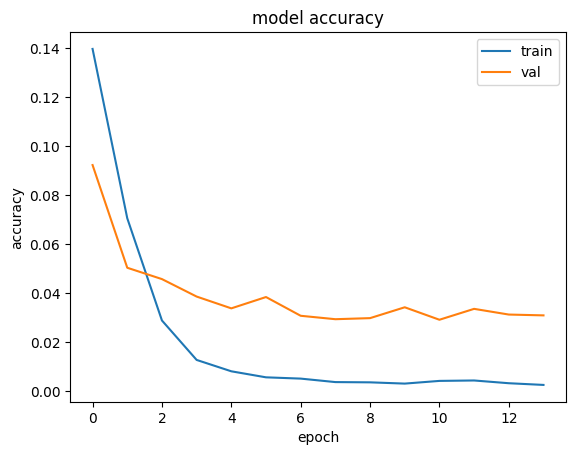

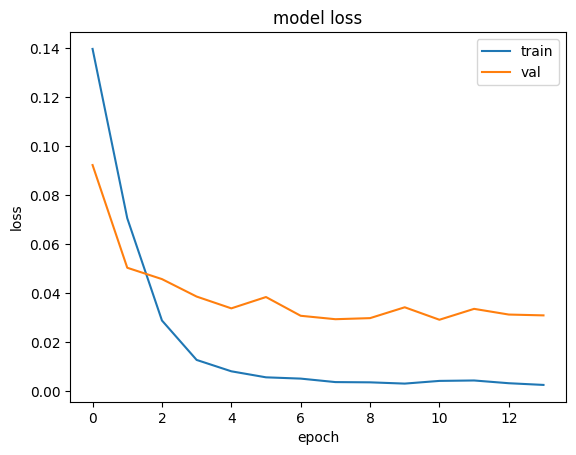

In [58]:
# Visualize the result
"""
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [59]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
print(y_pred.flatten())
y_pred_ = y_pred.copy()
for ind, val in enumerate(y_pred):
    if val < 1/3:
        res = 0
    elif val >2/3:
        res = 2
    else:
        res = 1        
    y_pred_[ind] = res
y_pred = y_pred_.astype('int8')
print(y_pred)

59/59 [==============================] - 1s 8ms/step
[9.9035597e-01 9.1388398e-01 9.9833274e-01 ... 1.0577831e-03 9.7532762e-04
 3.5666361e-01]
[2 2 2 ... 0 0 1]


In [60]:
# print(metrics.rand_score(y_test, y_pred))
formatted_y_test = (y_test*2).astype('int8')
print("Confusion Matrix:\n", metrics.confusion_matrix(formatted_y_test, y_pred))
print(f"Accuracy: {np.sum(np.equal(formatted_y_test, y_pred))/y_pred.shape[0]}")

Confusion Matrix:
 [[675  62  22]
 [ 30 518  45]
 [ 13  59 444]]
Accuracy: 0.8763383297644539
